In [1]:
import attack_kernelbased
import attack_fgsm
import attack_df
import attack_jsma
import attack_gen
import dataloader
import spatial

import torch
import torch.nn as nn
import numpy as np
import time
import onlinehd
import DNNmodels
import pickle
from sklearn.model_selection import train_test_split
import tqdm

In [2]:
X_train, X_test, y_train, y_test = dataloader.load(None, sklearn_dataset_name='Fashion-MNIST')

classes = y_train.unique().size(0)
features = X_train.size(1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

/Users/sang-geon/Documents/UCI_BIASLab/kernel_adversarial/venv/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(torch.Size([52500, 784]),
 torch.Size([17500, 784]),
 torch.Size([52500]),
 torch.Size([17500]))

In [3]:
X_test = X_test[:1000]
y_test = y_test[:1000]

In [4]:
D = 4000
model = onlinehd.OnlineHD(classes, features, dim=D)
model = model.fit(X_train, y_train, bootstrap=1.0, lr=0.035, epochs=2, one_pass_fit=False)

yhat_train = model(X_train)
yhat_test = model(X_test)

acc = (y_train == yhat_train).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(acc, acc_test)

tensor(0.8314) tensor(0.8560)


In [5]:
with open('./onlinehd_fmnist.pickle', 'bw') as f:
    pickle.dump(model, f)

In [6]:
with open('./onlinehd_fmnist.pickle', 'br') as f:
    model = pickle.load(f)

In [7]:
model_cnn = DNNmodels.CNN()
model_cnn.load_state_dict(torch.load('./model_cnn_fmnist.pt'))
model_cnn.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Kernel based attack

In [8]:
# with complex encoding (FHRR)
for e in np.linspace(0.01, 0.1, 10):#[0.01, 0.03, 0.07, 0.1]:
    st = time.time()
    X_test_noised = attack_kernelbased.genAdversarialNoise(model, X_test, y_test, e)
    print(time.time() - st)
    
    yhat_test = model(X_test_noised)
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, cnn_attacked_acc)

100%|██████████| 1000/1000 [00:43<00:00, 22.74it/s]


44.92878198623657
0.01 0.00855999905616045 0.800000011920929 0.8870000243186951


100%|██████████| 1000/1000 [00:44<00:00, 22.68it/s]


45.10186314582825
0.020000000000000004 0.0171199981123209 0.7260000109672546 0.8700000047683716


100%|██████████| 1000/1000 [00:43<00:00, 22.90it/s]


44.5936541557312
0.030000000000000006 0.025679999962449074 0.6470000147819519 0.8539999723434448


100%|██████████| 1000/1000 [00:43<00:00, 22.87it/s]


44.59595537185669
0.04000000000000001 0.0342399962246418 0.5809999704360962 0.8259999752044678


100%|██████████| 1000/1000 [00:43<00:00, 22.98it/s]


44.41587495803833
0.05000000000000001 0.04280000552535057 0.5180000066757202 0.800000011920929


100%|██████████| 1000/1000 [00:43<00:00, 23.07it/s]


44.25445508956909
0.06000000000000001 0.05135999992489815 0.4490000009536743 0.765999972820282


100%|██████████| 1000/1000 [00:43<00:00, 23.03it/s]


44.281004905700684
0.07 0.059919994324445724 0.40400001406669617 0.722000002861023


100%|██████████| 1000/1000 [00:43<00:00, 23.03it/s]


44.33806586265564
0.08 0.0684799924492836 0.3630000054836273 0.6819999814033508


100%|██████████| 1000/1000 [00:45<00:00, 21.90it/s]


46.611286878585815
0.09000000000000001 0.07704000920057297 0.3160000145435333 0.6499999761581421


100%|██████████| 1000/1000 [00:45<00:00, 22.01it/s]


46.402687072753906
0.1 0.08560001105070114 0.27399998903274536 0.6129999756813049


## FGSM

### Normlized

100%|██████████| 1000/1000 [00:05<00:00, 190.63it/s]



FGSM Attack with epsilon = 0.01000 | Elapsed time: 5.249791916000049 seconds.
Accuracy: Before the attack -> 85.60%	|	After the attack -> 85.50%
mean of norm=0.010000007227063179


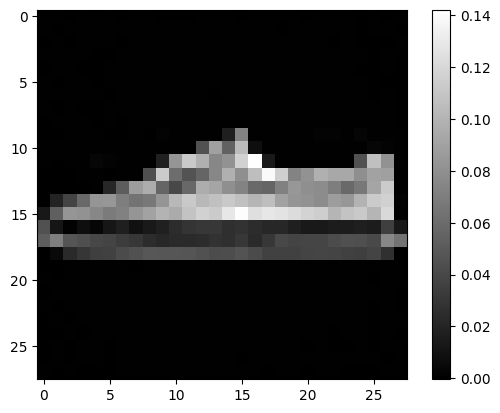

100%|██████████| 1000/1000 [00:05<00:00, 191.25it/s]



FGSM Attack with epsilon = 0.02000 | Elapsed time: 5.2361432919999515 seconds.
Accuracy: Before the attack -> 85.60%	|	After the attack -> 85.70%
mean of norm=0.020000014454126358


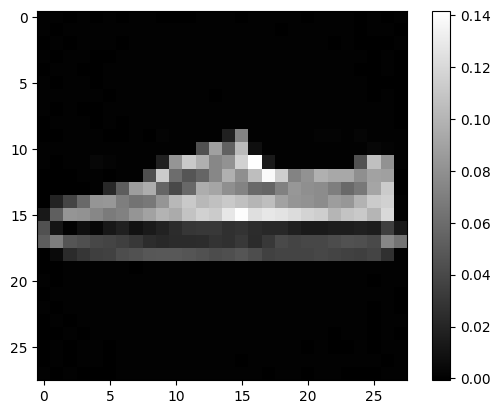

100%|██████████| 1000/1000 [00:05<00:00, 191.92it/s]



FGSM Attack with epsilon = 0.03000 | Elapsed time: 5.219585207999899 seconds.
Accuracy: Before the attack -> 85.60%	|	After the attack -> 85.60%
mean of norm=0.0299999862909317


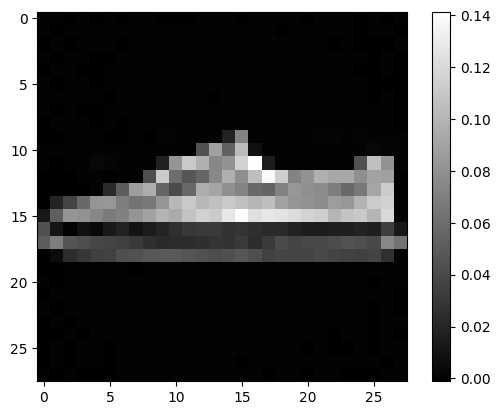

100%|██████████| 1000/1000 [00:05<00:00, 192.41it/s]



FGSM Attack with epsilon = 0.04000 | Elapsed time: 5.205041040999959 seconds.
Accuracy: Before the attack -> 85.60%	|	After the attack -> 85.20%
mean of norm=0.040000006556510925


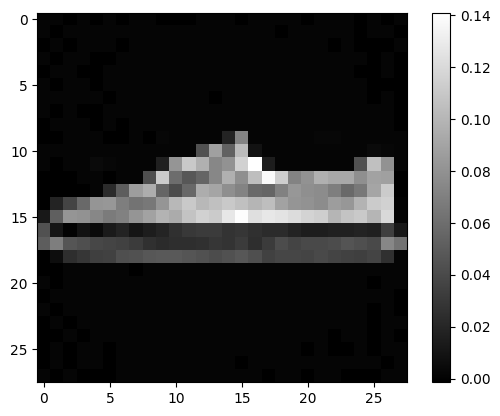

100%|██████████| 1000/1000 [00:05<00:00, 193.67it/s]



FGSM Attack with epsilon = 0.05000 | Elapsed time: 5.171791708000001 seconds.
Accuracy: Before the attack -> 85.60%	|	After the attack -> 84.90%
mean of norm=0.049999985843896866


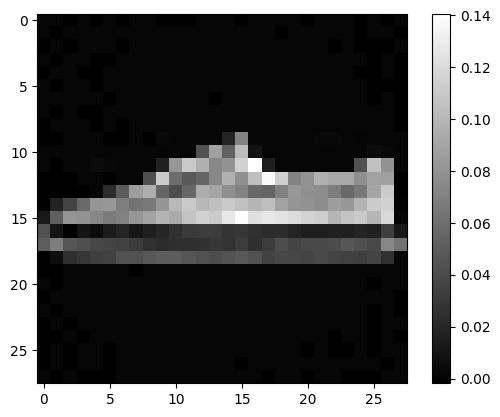

100%|██████████| 1000/1000 [00:05<00:00, 192.22it/s]



FGSM Attack with epsilon = 0.06000 | Elapsed time: 5.211073416999852 seconds.
Accuracy: Before the attack -> 85.60%	|	After the attack -> 84.60%
mean of norm=0.059999991208314896


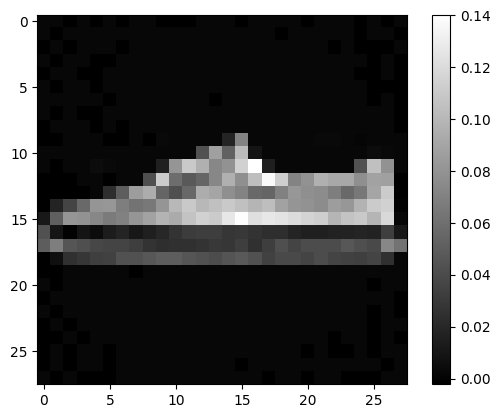

100%|██████████| 1000/1000 [00:05<00:00, 193.63it/s]



FGSM Attack with epsilon = 0.07000 | Elapsed time: 5.1729771249999885 seconds.
Accuracy: Before the attack -> 85.60%	|	After the attack -> 84.50%
mean of norm=0.07000000029802322


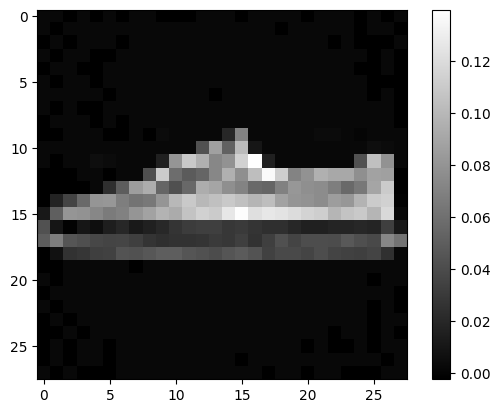

100%|██████████| 1000/1000 [00:05<00:00, 186.22it/s]



FGSM Attack with epsilon = 0.08000 | Elapsed time: 5.37841608299982 seconds.
Accuracy: Before the attack -> 85.60%	|	After the attack -> 84.30%
mean of norm=0.08000000566244125


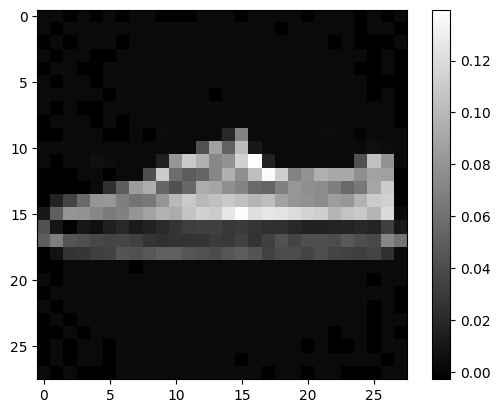

100%|██████████| 1000/1000 [00:05<00:00, 191.44it/s]



FGSM Attack with epsilon = 0.09000 | Elapsed time: 5.232558958000027 seconds.
Accuracy: Before the attack -> 85.60%	|	After the attack -> 84.40%
mean of norm=0.09000000357627869


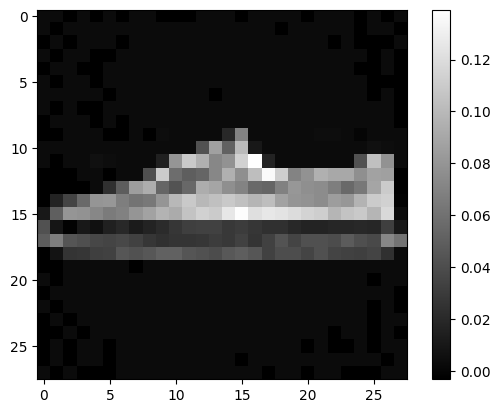

100%|██████████| 1000/1000 [00:05<00:00, 189.37it/s]



FGSM Attack with epsilon = 0.10000 | Elapsed time: 5.288862958999971 seconds.
Accuracy: Before the attack -> 85.60%	|	After the attack -> 84.20%
mean of norm=0.09999994933605194


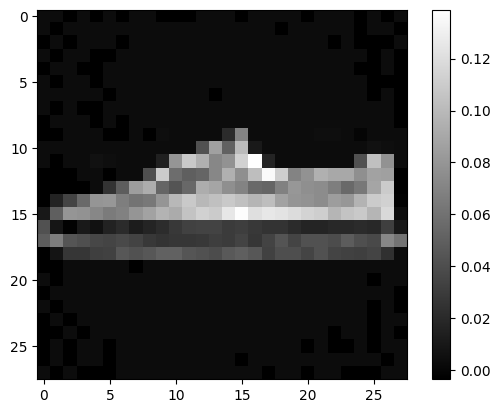

In [9]:
epsilons = np.linspace(0.01, 0.1, 10) # torch.Tensor([0.01, 0.03, 0.07, 0.1])
verbose = False
#criterion = nn.CosineEmbeddingLoss()
criterion = lambda output, model, label: (spatial.cos_cdist(output, model) - label).mean()
#criterion = lambda output, model, label: output.mean()
N_VAL_SAMPLES = X_test.data.shape[0]

attack_samples, acc_results = attack_fgsm.attack(
    model, X_train, X_test, y_test, epsilons, classes, criterion, N_VAL_SAMPLES, 'cpu')

In [10]:
for e, X_test_noised in zip(epsilons, attack_samples):
    yhat_test = model(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, cnn_attacked_acc)

0.01 0.010000007227063179 0.8550000190734863 0.8960000276565552
0.020000000000000004 0.020000014454126358 0.8569999933242798 0.8970000147819519
0.030000000000000006 0.0299999862909317 0.8560000061988831 0.8960000276565552
0.04000000000000001 0.040000006556510925 0.8519999980926514 0.8970000147819519
0.05000000000000001 0.049999985843896866 0.8489999771118164 0.8960000276565552
0.06000000000000001 0.059999991208314896 0.8460000157356262 0.8960000276565552
0.07 0.07000000029802322 0.8450000286102295 0.8939999938011169
0.08 0.08000000566244125 0.8429999947547913 0.8899999856948853
0.09000000000000001 0.09000000357627869 0.843999981880188 0.8880000114440918
0.1 0.09999994933605194 0.8420000076293945 0.8849999904632568


## Deep Fool

In [11]:
for max_update in np.linspace(0.01, 0.2, 20):
    X_te_cln = X_test.clone().reshape(-1, 1, 784)
    Y_te_cln = y_test.clone()

    x_test_adv = torch.zeros(X_te_cln.shape)
    x_test_pert = torch.zeros(X_te_cln.shape[0], 28, 28)

    st = time.time()
    for i in tqdm.tqdm(range(X_test.shape[0])):
        x_test_adv[i], x_test_pert[i] = attack_df.deepfool(X_te_cln[i], model, epsilon=max_update)
    print(time.time() - st)
    
    X_test_noised = x_test_adv.reshape(-1, features)

    yhat_test = model(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(max_update, distance, onlinehd_attacked_acc, cnn_attacked_acc)

100%|██████████| 1000/1000 [02:20<00:00,  7.12it/s]


140.36864686012268
0.01 0.006655694916844368 0.8299999833106995 0.8949999809265137


100%|██████████| 1000/1000 [02:03<00:00,  8.11it/s]


123.36547303199768
0.02 0.013311389833688736 0.777999997138977 0.8849999904632568


100%|██████████| 1000/1000 [01:43<00:00,  9.66it/s]


103.53440618515015
0.03 0.019967086613178253 0.7160000205039978 0.8740000128746033


100%|██████████| 1000/1000 [01:24<00:00, 11.79it/s]


84.81257700920105
0.04 0.026622779667377472 0.6539999842643738 0.8489999771118164


100%|██████████| 1000/1000 [01:16<00:00, 13.12it/s]


76.21493101119995
0.05 0.03327848017215729 0.5899999737739563 0.8339999914169312


100%|██████████| 1000/1000 [01:07<00:00, 14.81it/s]


67.53436422348022
0.060000000000000005 0.03993416950106621 0.5299999713897705 0.8040000200271606


100%|██████████| 1000/1000 [01:02<00:00, 15.94it/s]


62.74187898635864
0.06999999999999999 0.046589866280555725 0.4909999966621399 0.7649999856948853


100%|██████████| 1000/1000 [00:59<00:00, 16.82it/s]


59.4417679309845
0.08 0.053245555609464645 0.46399998664855957 0.7269999980926514


100%|██████████| 1000/1000 [00:58<00:00, 17.22it/s]


58.085487842559814
0.09 0.059901267290115356 0.44200000166893005 0.699999988079071


100%|██████████| 1000/1000 [00:57<00:00, 17.48it/s]


57.20438504219055
0.09999999999999999 0.06655696034431458 0.4259999990463257 0.671999990940094


100%|██████████| 1000/1000 [00:55<00:00, 17.97it/s]


55.636903285980225
0.11 0.0732126533985138 0.41200000047683716 0.6320000290870667


100%|██████████| 1000/1000 [00:54<00:00, 18.44it/s]


54.234270334243774
0.12 0.07986834645271301 0.40299999713897705 0.6010000109672546


100%|██████████| 1000/1000 [00:54<00:00, 18.40it/s]


54.36234426498413
0.13 0.08652403205633163 0.4009999930858612 0.5720000267028809


100%|██████████| 1000/1000 [00:53<00:00, 18.74it/s]


53.3531539440155
0.14 0.09317973256111145 0.39500001072883606 0.5540000200271606


100%|██████████| 1000/1000 [00:53<00:00, 18.77it/s]


53.271228313446045
0.15000000000000002 0.09983542561531067 0.39100000262260437 0.5320000052452087


100%|██████████| 1000/1000 [00:52<00:00, 19.04it/s]


52.52904510498047
0.16 0.10649111121892929 0.38999998569488525 0.5080000162124634


100%|██████████| 1000/1000 [00:52<00:00, 19.11it/s]


52.32731223106384
0.17 0.1131468191742897 0.3880000114440918 0.48500001430511475


100%|██████████| 1000/1000 [00:51<00:00, 19.24it/s]


51.978760957717896
0.18000000000000002 0.11980253458023071 0.38499999046325684 0.4699999988079071


100%|██████████| 1000/1000 [00:51<00:00, 19.26it/s]


51.92229914665222
0.19 0.12645822763442993 0.38499999046325684 0.45899999141693115


100%|██████████| 1000/1000 [00:52<00:00, 19.08it/s]


52.40455198287964
0.2 0.13311392068862915 0.38499999046325684 0.4480000138282776


In [12]:
X_te_cln = X_test.clone().reshape(-1, 1, 784)
Y_te_cln = y_test.clone()

x_test_adv = torch.zeros(X_te_cln.shape)
x_test_pert = torch.zeros(X_te_cln.shape[0], 28, 28)

for i in tqdm.tqdm(range(X_test.shape[0])):
    x_test_adv[i], x_test_pert[i] = attack_df.deepfool(X_te_cln[i], model, epsilon=None)

X_test_noised = x_test_adv.reshape(-1, features)

yhat_test = model(X_test_noised.reshape(-1, 28*28))
yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

print(None, distance, onlinehd_attacked_acc, cnn_attacked_acc)

100%|██████████| 1000/1000 [00:51<00:00, 19.31it/s]


None 0.0867491289973259 0.3840000033378601 0.6079999804496765


## Genetic Attack

In [13]:
alpha_lis = np.linspace(0.0001, 0.0015, 20) #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen.make_GA(model, delta, alpha, x_test_samp, y_test_samp)
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, cnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.0001


100%|██████████| 1000/1000 [1:42:57<00:00,  6.18s/it]


6177.582678079605
0.0001 0.023659124970436096 0.847000002861023 0.8980000019073486
Alpha : 0.0001736842105263158


100%|██████████| 1000/1000 [1:32:26<00:00,  5.55s/it]


5546.920253992081
0.0001736842105263158 0.04149975627660751 0.8479999899864197 0.8970000147819519
Alpha : 0.0002473684210526316


100%|██████████| 1000/1000 [1:27:28<00:00,  5.25s/it]


5248.997385025024
0.0002473684210526316 0.06000766530632973 0.8420000076293945 0.8989999890327454
Alpha : 0.00032105263157894735


100%|██████████| 1000/1000 [1:27:31<00:00,  5.25s/it]


5251.294975042343
0.00032105263157894735 0.07421847432851791 0.8289999961853027 0.8949999809265137
Alpha : 0.00039473684210526315


100%|██████████| 1000/1000 [1:27:12<00:00,  5.23s/it]


5232.661860227585
0.00039473684210526315 0.08271726965904236 0.8230000138282776 0.8999999761581421
Alpha : 0.00046842105263157895


100%|██████████| 1000/1000 [1:26:50<00:00,  5.21s/it]


5210.524631023407
0.00046842105263157895 0.09307748824357986 0.8230000138282776 0.8859999775886536
Alpha : 0.0005421052631578948


100%|██████████| 1000/1000 [1:29:47<00:00,  5.39s/it]


5387.483270168304
0.0005421052631578948 0.10155732929706573 0.8220000267028809 0.8949999809265137
Alpha : 0.0006157894736842106


100%|██████████| 1000/1000 [1:28:15<00:00,  5.30s/it]


5295.520163059235
0.0006157894736842106 0.1087067723274231 0.8090000152587891 0.8980000019073486
Alpha : 0.0006894736842105264


  4%|▍         | 41/1000 [03:40<1:25:56,  5.38s/it]